[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/notebooks/test8.ipynb)

In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
# general
import os
import numpy as np
from tqdm import tqdm
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
# plotting
import matplotlib.pyplot as plt
import arviz
from getdist import plots, MCSamples
# numpyro
import numpyro
import numpyro.distributions as npyro_dist
from numpyro.infer import MCMC, NUTS
# # NF
import torch
import pyro
import pyro.distributions as pyro_dist
import pyro.distributions.transforms as T
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Development notebook 8

$\providecommand{\d}{\mathrm{d}}$
$\providecommand{\D}{\mathcal{D}}$

We do the same as notebook 7 but use $n\geq3$ here.

In [3]:
def action_iphi(z, y):
    z2 = jnp.dot(z, z)
    zy = jnp.dot(z, y)
    iphi = 1j*(z2 - 2*zy)
    return iphi

def action_h(z, y):
    s = action_iphi(z, y)
    h = jnp.real(s) + 0.0j
    return h

def action_Seff(z, y):
    seff = -action_iphi(z, y)
    return seff

def integrand(z, y):
    return jnp.exp(action_iphi(z, y))

# corresponding gradients
grad_iphi = grad(action_iphi, holomorphic=True)
grad_h    = grad(action_h, holomorphic=True)
grad_Seff = grad(action_Seff, holomorphic=True)

In [4]:
def flow_step(z, y, ds, thre=0.1):
    dSdz = grad_Seff(z, y)
    z = z + ds*jnp.conj(dSdz)
    return z

def flow_n_steps(x, y, ds, n_step):
    z = x.astype(complex)
    fnc = lambda z, null: (flow_step(z, y, ds), null)
    z, null = scan(fnc, z, length=n_step)
    return z

def flow_n_steps_with_jac(x, y, ds, n_step):
    z = flow_n_steps(x, y, ds, n_step)
    # Jacobian (we do this because the func is complex)
    def split(x, y, ds, n_step):
        f = flow_n_steps(x, y, ds, n_step)
        return jnp.real(f), jnp.imag(f)
    j = jacobian(split, argnums=0)(x, y, ds, n_step)
    j = j[0] + j[1]*1j
    j = jnp.linalg.det(j)

    return z, j

vflow = vmap(flow_n_steps_with_jac, (0,None,None,None), 0)

In [5]:
def model():
    # Define a prior for `x`
    x = []
    for i in range(ndim):
        xi = numpyro.sample('x{}'.format(i+1), npyro_dist.Uniform(-6, 6))
        x.append(xi)
    x = jnp.array(x)

    # context param
    y = []
    for i in range(ndim):
        yi = numpyro.sample('y{}'.format(i+1), npyro_dist.Uniform(-5, 5))
        y.append(yi)
    y = jnp.array(y)

    # flow
    # n_step in flow should be optimized depending on the dimension...
    z_pl, j = flow_n_steps_with_jac(x, y, 1e-3, 400)
    i = integrand(z_pl, y)

    amplt = jnp.abs(i*j)
    phase = i*j/amplt

    # likelihood
    numpyro.factor('loglike', jnp.log(amplt))

    # save derived parameters
    numpyro.deterministic('phase'    , phase)
    numpyro.deterministic('amplitude', amplt)


In [6]:
ndim = 5
# Set up and run the HMC sampler
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=10000)
with jax.default_device(cpu_device):
    mcmc.run(jax.random.PRNGKey(0))

# Get samples
samples_raw = mcmc.get_samples()
# convert to jnp
# samples = jnp.transpose(jnp.array([samples_raw['x{}'.format(i+1)] for i in range(ndim)]))
# samples = jnp.transpose(jnp.array([samples_raw['x1'] , samples_raw['y'][:,0]]))
# samples = jnp.transpose(jnp.array([samples_raw['x1'] , samples_raw['y']]))
samples = jnp.transpose(jnp.array([samples_raw['x{}'.format(i+1)] for i in range(ndim)] +\
                                    [samples_raw['y{}'.format(i+1)] for i in range(ndim)]))

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
  0%|          | 0/10500 [00:00<?, ?it/s]/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/jax/_src/lax/lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 10500/10500 [01:22<00:00, 126.59it/s, 63 steps of size 7.80e-02. acc. prob=0.89]


Removed no burn in


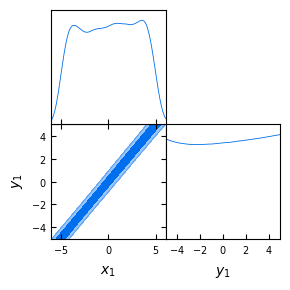

In [7]:
names = ['x{}'.format(i+1) for i in range(ndim) ] + ['y{}'.format(i+1) for i in range(ndim) ]
labels= ['x_{}'.format(i+1) for i in range(ndim)] + ['y_{}'.format(i+1) for i in range(ndim)]
ranges= {name: (-6,6) if 'x' in name else (-5,5) for name in names}
mcsamples = MCSamples(samples=samples, names=names, labels=labels, ranges=ranges)
g = plots.get_subplot_plotter(width_inch=3)
g.triangle_plot(mcsamples, ['x1', 'y1'], filled=True)
plt.show()

Now we train the conditional probability $P(x|y)$ from the samples.

In [8]:
import flax.linen as nn
import optax
from sklearn import datasets, preprocessing
from tqdm import tqdm

import sys
sys.path.append("../")

from models.maf import MaskedAutoregressiveFlow
from models.nsf import NeuralSplineFlow

In [9]:
n_dim = ndim
n_context = ndim

# flow_model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=12, activation="tanh", use_random_permutations=False)
flow_model = MaskedAutoregressiveFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=8, activation="tanh", use_random_permutations=False)
# flow_model = NeuralSplineFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[128,128], n_transforms=8, activation="gelu", n_bins=16, range_min=-2, range_max=2,)
# flow_model = NeuralSplineFlow(n_dim=n_dim, n_context=n_context, hidden_dims=[32,32], n_transforms=4, activation="gelu", n_bins=16, range_min=-2, range_max=2,)

# Initialize model
key = jax.random.PRNGKey(42)
x_test = jax.random.uniform(key=key, shape=(64, n_dim))
context = jax.random.uniform(key=key, shape=(64, n_context))
params = flow_model.init(key, x_test, context)

In [10]:
optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(params)

@jax.jit
def loss_fn(params, x, context):
    loss = -jnp.mean(flow_model.apply(params, x, context))
    return loss

@jax.jit
def update(params, opt_state, batch):
    x, context = batch
    grads = jax.grad(loss_fn)(params, x, context)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

In [11]:
%%time
batch_size = 64
# n_steps = 10_000
n_steps = 1_000
# n_steps = 100
loss_history = []

key = jax.random.PRNGKey(0)
for step in tqdm(range(n_steps)):
    # Generate random batch
    # data_batch = samples[np.random.choice(samples.shape[0], batch_size)]
    key, subkey = jax.random.split(key) # Split key
    indices = jax.random.choice(subkey, samples.shape[0], shape=(batch_size,), replace=False)
    data_batch = samples[indices]
    x_batch = data_batch[:,:ndim]
    y_batch = data_batch[:,ndim:]

    # Update
    batch = (x_batch, y_batch)
    params, opt_state = update(params, opt_state, batch)

    # Save loss
    loss_history.append(loss_fn(params, x_batch, y_batch))

100%|██████████| 1000/1000 [01:42<00:00,  9.76it/s]

CPU times: user 1min 34s, sys: 23.9 s, total: 1min 58s
Wall time: 1min 42s


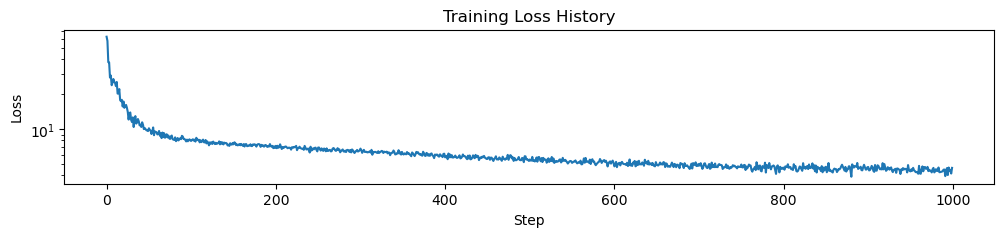

In [12]:
# Plot loss
plt.figure(figsize=(12, 2))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

In [13]:
def sample_from_flow(y, n_samples=10_000, key=jax.random.PRNGKey(42)):
    """Helper function to sample from the flow model.
    """
    if len(y.shape) == 1:
        y = jnp.ones((n_samples, n_context))*y[None, :]
    assert y.shape == (n_samples, n_context), f"Context shape should be (n_samples, n_context), got {y.shape}"

    def sample_fn(flow_model):
        x_samples = flow_model.sample(num_samples=n_samples, rng=key, 
                        context=y)
        return x_samples

    x_samples = nn.apply(sample_fn, flow_model)(params)
    x_samples = jnp.array(x_samples)
    return x_samples

In [14]:
y = jnp.arange(10_000 * ndim).reshape(10_000, ndim)
x = sample_from_flow(y, n_samples=10_000)
y.shape, x.shape

((10000, 5), (10000, 5))

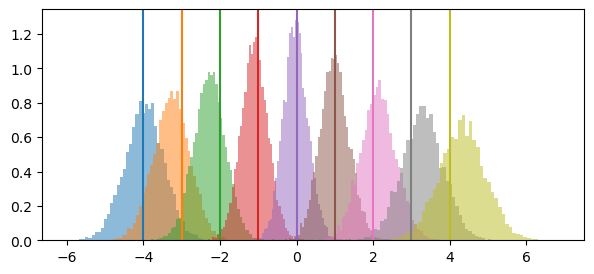

In [15]:
plt.figure(figsize=(7, 3))
for j, y in enumerate([-4, -3, -2, -1, 0, 1, 2, 3, 4]):
    _ = jnp.array([y]+[0]*(ndim-1))
    x = sample_from_flow(y=_, n_samples=10_000, key=jax.random.PRNGKey(42))
    plt.hist(x[:,0], bins=50, density=True, alpha=0.5, label="Flow", color='C{}'.format(j))
    plt.axvline(y, color='C{}'.format(j))
plt.show()

In [16]:
n_samples = 10_000
y_flow = jax.random.uniform(key=jax.random.PRNGKey(40), shape=(n_samples,n_context), minval=-5, maxval=5)
x_flow = sample_from_flow(y=y_flow, n_samples=n_samples, key=jax.random.PRNGKey(42))

Removed no burn in
Removed no burn in


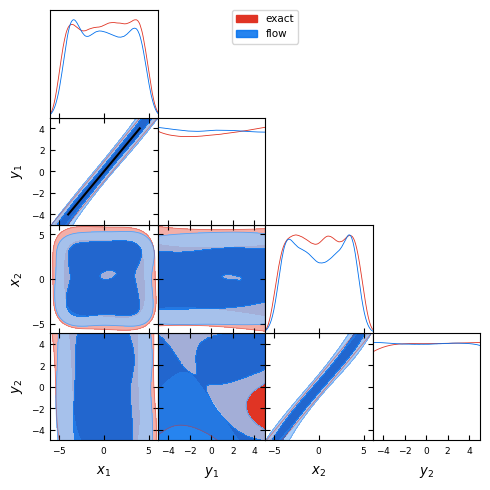

In [17]:
mcsamples = MCSamples(samples=samples, names=names, labels=labels, ranges=ranges, label='exact')
mcsamples_flow = MCSamples(samples=np.hstack([x_flow, y_flow]), names=names, labels=labels, ranges=ranges, label='flow')
g = plots.get_subplot_plotter(width_inch=5)
g.triangle_plot([mcsamples, mcsamples_flow], ['x1', 'y1', 'x2', 'y2'], filled=True, alpha=0.6)
ax = g.get_axes((1,0))
_ = np.linspace(-4,4, 10)
ax.plot(_,_, color='k')
plt.show()

Okay!

In [18]:
def log_prob_from_flow(x, y):
    """Helper function to evaluate logprob
    """
    if len(x.shape) == 1:
        n_samples = 1
        x = jnp.ones((n_samples, n_dim))*x[None, :]
    else:
        n_samples = x.shape[0]
    assert x.shape == (n_samples, n_dim)
    if len(y.shape) == 1:
        y = jnp.ones((n_samples, n_context))*y[None, :]
    assert y.shape == (n_samples, n_context)
    
    def logprob_fn(flow_model):
        x_samples = flow_model(x, y)
        return x_samples

    log_prob = nn.apply(logprob_fn, flow_model)(params)
    return log_prob

In [19]:
y1 = jnp.pi**0.5
y_flow = jnp.array([y1]+[0.0]*(ndim-1))
y_sample = y_flow
%time x_flow = sample_from_flow(y=y_sample, n_samples=10_000, key=jax.random.PRNGKey(42))
%time logp = log_prob_from_flow(x_flow, y_flow)

CPU times: user 647 ms, sys: 170 ms, total: 816 ms
Wall time: 653 ms
CPU times: user 3.24 s, sys: 611 ms, total: 3.85 s
Wall time: 3.51 s


In [20]:
%time z_pl, j = vflow(x_flow, y_flow, 1e-3, 400)
%time i = vmap(integrand, (0, None), 0)(z_pl, y_flow)
Z_pl = jnp.mean( i*j*jnp.exp(-logp) )

CPU times: user 2.4 s, sys: 157 ms, total: 2.56 s
Wall time: 2.36 s
CPU times: user 350 ms, sys: 17.2 ms, total: 367 ms
Wall time: 401 ms


In [21]:
Z_ana = jnp.exp(-1j*jnp.dot(y_flow,y_flow)) * ((1+1j)*jnp.sqrt(jnp.pi/2))**ndim

In [22]:
print('Z_pl :', Z_pl)
print('Z_ana:', Z_ana)

Z_pl : (12.09167+12.530345j)
Z_ana: (12.369717+12.369715j)


In [23]:
def eval_Z_pl(y, x_flow=None, logp=None):
    y_flow = y
    if x_flow is None:
        x_flow = sample_from_flow(y=y_flow, n_samples=1_000, key=jax.random.PRNGKey(42))
    if logp is None:
        logp = log_prob_from_flow(x_flow, y_flow)

    z_pl, j = vflow(x_flow, y_flow, 1e-3, 400)
    i = vmap(integrand, (0, None), 0)(z_pl, y_flow)

    Z_pl = jnp.mean( i*j*jnp.exp(-logp) )

    return Z_pl

In [24]:
y1 = jnp.linspace(-2, 2, 500)
y = jnp.transpose(jnp.array([y1]+[jnp.zeros_like(y1)]*(ndim-1)))

In [25]:
%time Z_pl = vmap(eval_Z_pl, (0,None,None), 0)(y, None, None)

CPU times: user 2min 34s, sys: 1min 38s, total: 4min 13s
Wall time: 1min 37s


In [26]:
Z_ana = jnp.exp(-1j*jnp.sum(y**2, axis=1)) * ((1+1j)*jnp.sqrt(jnp.pi/2))**ndim

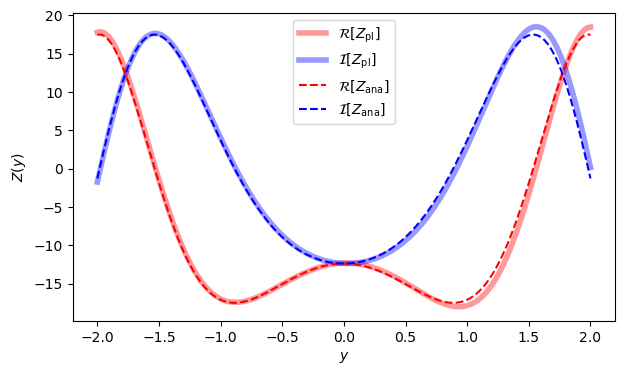

In [27]:
plt.figure(figsize=(7, 4))
plt.plot(y1, jnp.real(Z_pl) , 'r-' , label=r'$\mathcal{R}[Z_{\rm pl}]$', alpha=0.4, lw=4)
plt.plot(y1, jnp.imag(Z_pl) , 'b-' , label=r'$\mathcal{I}[Z_{\rm pl}]$', alpha=0.4, lw=4)
plt.plot(y1, jnp.real(Z_ana), 'r--', label=r'$\mathcal{R}[Z_{\rm ana}]$')
plt.plot(y1, jnp.imag(Z_ana), 'b--', label=r'$\mathcal{I}[Z_{\rm ana}]$')
plt.xlabel(r'$y$')
plt.ylabel(r'$Z(y)$')
plt.legend()
plt.show()

## Introducing the wave number $w$

The flow equation is identical for any $w$ after rescaling flow time parameter, so the necessary modification is only on integrand.


$$
Z = \int\d x e^{iw(x^2-2xy)} = e^{-iwy^2}\int\d x e^{iwx^2} = w^{-n/2} e^{-iwy^2} \left[(1+i)\sqrt{\pi/2}\right]^n
$$

In [28]:
def eval_Z_pl(y, w=1, x_flow=None, logp=None):
    w_is_scalar = jnp.isscalar(w)
    if w_is_scalar:
        w = jnp.array([w])

    y_flow = y
    if x_flow is None:
        x_flow = sample_from_flow(y=y_flow, n_samples=1_000, key=jax.random.PRNGKey(42))
    if logp is None:
        logp = log_prob_from_flow(x_flow, y_flow)

    z_pl, j = vflow(x_flow, y_flow, 1e-3, 400)
    i = vmap(integrand, (0, None), 0)(z_pl, y_flow)

    Z_pl = jnp.mean( i[:,None]**w[None,:]*j[:,None]*jnp.exp(-logp[:,None]), axis=0)

    if w_is_scalar:
        Z_pl = Z_pl[0]

    return Z_pl

In [29]:
w = jnp.logspace(0, 2, 10)
%time Z_pl = vmap(eval_Z_pl, (0,None,None,None), 0)(y, w, None, None)

CPU times: user 2min 35s, sys: 1min 38s, total: 4min 13s
Wall time: 1min 32s


In [30]:
Z_ana = jnp.exp(-1j*w[None,:]*jnp.sum(y**2, axis=1)[:,None]) * ((1+1j)*jnp.sqrt(jnp.pi/2/w[None,:]))**ndim

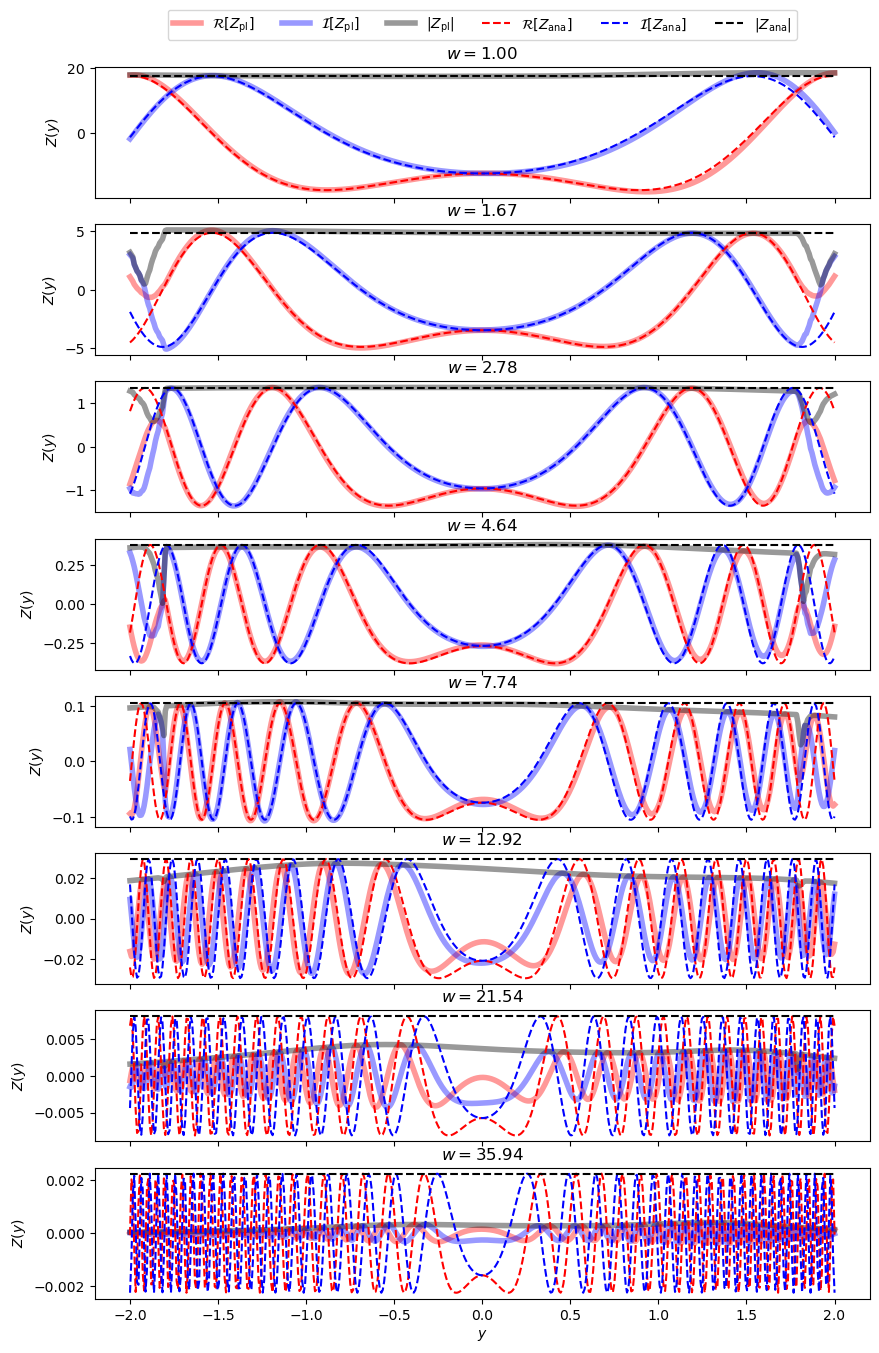

In [31]:
nplot = min(w.size, 8)

fig, axes = plt.subplots(nplot, 1, figsize=(10, 2*nplot), sharex=True)
for i in range(nplot):
    ax = axes[i]
    ax.set_title(r'$w={:.2f}$'.format(w[i]))
    ax.plot(y1, jnp.real(Z_pl[:,i]) , 'r-' , label=r'$\mathcal{R}[Z_{\rm pl}]$', alpha=0.4, lw=4)
    ax.plot(y1, jnp.imag(Z_pl[:,i]) , 'b-' , label=r'$\mathcal{I}[Z_{\rm pl}]$', alpha=0.4, lw=4)
    ax.plot(y1, jnp.abs (Z_pl[:,i]) , 'k-' , label=r'$|Z_{\rm pl}|$', alpha=0.4, lw=4)
    ax.plot(y1, jnp.real(Z_ana[:,i]), 'r--', label=r'$\mathcal{R}[Z_{\rm ana}]$')
    ax.plot(y1, jnp.imag(Z_ana[:,i]), 'b--', label=r'$\mathcal{I}[Z_{\rm ana}]$')
    ax.plot(y1, jnp.abs (Z_ana[:,i]), 'k--', label=r'$|Z_{\rm ana}|$')
    ax.set_ylabel(r'$Z(y)$')
plt.xlabel(r'$y$')
axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.15), ncol=6)
plt.show()